# Open your new rest

- this repo includes insightful data analysis and visualizations on cafes and restaurants which are reviewed and rated on database in Bangkok.
- Rate column is the target column and we will create regression model pipelines to get best results
- Reviews_list column will be handled seperately by NLP to analye restaurants deeply


In [2]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np

# For Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objs as go
from geopy.geocoders import Nominatim
import folium
from folium.plugins import HeatMap
from folium.plugins import FastMarkerCluster
from tqdm import tqdm
from plotly import tools
import re
from plotly.offline import init_notebook_mode, plot, iplot


## PrePro

#### read

In [55]:
df = pd.read_csv('./dbs/zomato.csv')

In [56]:
df.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


In [4]:
df.info()
# we can fill nulls in location column with adress column info and also fill rates with rates in review_list rates 
# dish liked nulls fill be filled with None value to imply nothing we can't drop null values in the column
# url adress phone columns are useless for our analysis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   url                          51717 non-null  object
 1   address                      51717 non-null  object
 2   name                         51717 non-null  object
 3   online_order                 51717 non-null  object
 4   book_table                   51717 non-null  object
 5   rate                         43942 non-null  object
 6   votes                        51717 non-null  int64 
 7   phone                        50509 non-null  object
 8   location                     51696 non-null  object
 9   rest_type                    51490 non-null  object
 10  dish_liked                   23639 non-null  object
 11  cuisines                     51672 non-null  object
 12  approx_cost(for two people)  51371 non-null  object
 13  reviews_list                 51

In [57]:
df.drop_duplicates(inplace=True)

In [58]:
df = df.rename(columns={'approx_cost(for two people)':'cost','listed_in(type)':'type',
                                  'listed_in(city)':'city'})

In [7]:
df['rate']

0         4.1/5
1         4.1/5
2         3.8/5
3         3.7/5
4         3.8/5
          ...  
51712    3.6 /5
51713       NaN
51714       NaN
51715    4.3 /5
51716    3.4 /5
Name: rate, Length: 51717, dtype: object

#### Deal columns one by one

##### menu_item

In [8]:
df.loc[df['menu_item'] != '[]'].count()
# nearly 4/5 of columns don't have menu item info maybe it is better the drop menu_item column

url             12100
address         12100
name            12100
online_order    12100
book_table      12100
rate            11383
votes           12100
phone           11983
location        12100
rest_type       12060
dish_liked       6852
cuisines        12095
cost            12100
reviews_list    12100
menu_item       12100
type            12100
city            12100
dtype: int64

In [9]:
df['dish_liked'].iloc[1500]

nan

##### reviews_list
we will check nan values in rate column and try to fill them with rates in reviews_list if rate is null and reviews_list = [] we will drop the row

In [10]:
df['rate'].isnull().value_counts()
# we have 7775 null rate

False    43942
True      7775
Name: rate, dtype: int64

In [59]:
df2= df.copy()

In [12]:
df2[df2['reviews_list']=='[]'].count()

url             7595
address         7595
name            7595
online_order    7595
book_table      7595
rate            2321
votes           7595
phone           7337
location        7574
rest_type       7525
dish_liked       183
cuisines        7565
cost            7543
reviews_list    7595
menu_item       7595
type            7595
city            7595
dtype: int64

In [60]:
prr = df[df['rate'].isna()]

In [61]:
prr[prr['reviews_list'] != '[]'].count()
# we can fill 2501 of nan rate

url             2501
address         2501
name            2501
online_order    2501
book_table      2501
rate               0
votes           2501
phone           2348
location        2501
rest_type       2492
dish_liked        27
cuisines        2495
cost            2452
reviews_list    2501
menu_item       2501
type            2501
city            2501
dtype: int64

In [62]:
indi  = prr[prr['reviews_list'] == '[]' ].index
df2.drop(indi,inplace=True)

In [272]:
df2[df2['rate'].isna()].count()

url             2501
address         2501
name            2501
online_order    2501
book_table      2501
rate               0
votes           2501
phone           2348
location        2501
rest_type       2492
dish_liked        27
cuisines        2495
cost            2452
reviews_list    2501
menu_item       2501
type            2501
city            2501
dtype: int64

In [63]:
df2.reset_index(inplace=True)

In [274]:
df2['rate'].isna().value_counts()
# we are going to fill this 2501 rate row now

False    43942
True      2501
Name: rate, dtype: int64

In [64]:
pat = re.compile('Rated [0-9]*\.[0-9]+',)
cs = []
for i in range(len(df2['reviews_list'])):

    rates = pat.findall(df2['reviews_list'][i])
    k = 0
    
    for rate in rates:
        k = k+int(rate.split('Rated ')[1].split('.')[0])
    if len(rates) != 0:
        if(pd.isnull(df2['rate'][i])):
            k = k/len(rates)
            cs.append(round(k,2))
        else:
            cs.append(df2['rate'][i])
    else:
        cs.append(df2['rate'][i])
    # [int(rate.split('Rated ')[1].split('.')[0]) for rate in rates]

In [65]:

for i in range(len(df2['rate'])):
    df2['rate'][i] = cs[i]
df2['rate']

C:\Users\emreb\AppData\Local\Temp\ipykernel_15136\4222410133.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0         4.1/5
1         4.1/5
2         3.8/5
3         3.7/5
4         3.8/5
          ...  
46438       4.0
46439    2.5 /5
46440    3.6 /5
46441    4.3 /5
46442    3.4 /5
Name: rate, Length: 46443, dtype: object

Now we are done with ratings in reviews list we can substract them, cause they are useless

In [299]:
deleterate = ['Rated [0-9]*\.[0-9]+','RATED',"\n"]

for dele in deleterate:


    df2['reviews_list']=df2['reviews_list'].apply(lambda x : re.sub(dele,"",x))

In [319]:
df2 = df2.loc[df2.rate !='NEW']
df2 = df2.loc[df2.rate !='-'].reset_index(drop=True)
remove_slash = lambda x: x.replace('/5', '') if type(x) == np.str else x
df2.rate = df2.rate.apply(remove_slash).str.strip().astype('float')
df2['rate'].head()

C:\Users\emreb\AppData\Local\Temp\ipykernel_8924\1872025914.py:3: DeprecationWarning:

`np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



0    4.1
1    4.1
2    3.8
3    3.7
4    3.8
Name: rate, dtype: float64

In [320]:
len(df2)

44166

In [ ]:
df2.info()
# rest_type has a tiny misings, dish_liked is I donnow, we can fill approx_cost with mean

#### Approx_cost

In [321]:
df3 = df2.copy()

In [322]:
df3.dropna(inplace=True,subset='cost')

In [323]:
df3.reset_index(inplace=True)

In [324]:
df3['cost'] = df3['cost'].astype(str).apply(lambda x: x.replace(',', ''))

In [325]:
df4=df3.copy()

In [33]:
# def convertto_int(df,columns):
#     for col in columns:
#         for i in range(len(df[col])):
#             if pd.isnull(df[col][i]) == False:
#                 df[col] = df[col].astype('int64')
#             else:
#                 pass

# col = ['cost']
# convertto_int(df4,col)

In [326]:
pd.to_numeric(df4['cost'])

0         800
1         800
2         800
3         300
4         600
         ... 
43865     900
43866     800
43867    1500
43868    2500
43869    1500
Name: cost, Length: 43870, dtype: int64

In [36]:
# type(df4['rate'][1])

numpy.float64

In [37]:
# df4['cost'].isna().value_counts()

False    43870
Name: cost, dtype: int64

In [35]:
# df2['cost'].fillna(df2['cost'].mean())

In [327]:
df4= df4.drop(['url','phone'],axis=1)

In [328]:
df4= df4.drop('dish_liked',axis=1)

In [329]:
df4.dropna(inplace=True)
df4.reset_index(drop=True)

,level_0,index,address,name,online_order,book_table,rate,votes,location,rest_type,cuisines,cost,reviews_list,menu_item,type,city
0,0,0,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1,775,Banashankari,Casual Dining,"North Indian, Mughlai, Chinese",800,"[('', '\n A beautiful place to dine in.The in...",[],Buffet,Banashankari
1,1,1,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1,787,Banashankari,Casual Dining,"Chinese, North Indian, Thai",800,"[('', '\n Had been here for dinner with famil...",[],Buffet,Banashankari
2,2,2,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8,918,Banashankari,"Cafe, Casual Dining","Cafe, Mexican, Italian",800,"[('', ""\n Ambience is not that good enough an...",[],Buffet,Banashankari
3,3,3,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7,88,Banashankari,Quick Bites,"South Indian, North Indian",300,"[('', ""\n Great food and proper Karnataka sty...",[],Buffet,Banashankari
4,4,4,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8,166,Basavanagudi,Casual Dining,"North Indian, Rajasthani",600,"[('', '\n Very good restaurant in neighbourho...",[],Buffet,Banashankari
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41258,44160,51709,"136, SAP Labs India, KIADB Export Promotion In...",The Farm House Bar n Grill,No,No,3.7,34,Whitefield,"Casual Dining, Bar","North Indian, Continental",800,"[('', '\n Ambience- Big and spacious lawn was...",[],Pubs and bars,Whitefield
41259,44162,51711,"139/C1, Next To GR Tech Park, Pattandur Agraha...",Bhagini,No,No,2.5,81,Whitefield,"Casual Dining, Bar","Andhra, South Indian, Chinese, North Indian",800,"[('', '\n A fine place to chill after office ...",[],Pubs and bars,Whitefield
41260,44163,51712,"Four Points by Sheraton Bengaluru, 43/3, White...",Best Brews - Four Points by Sheraton Bengaluru...,No,No,3.6,27,Whitefield,Bar,Continental,1500,"[('', ""\n Food and service are incomparably e...",[],Pubs and bars,Whitefield
41261,44164,51715,Sheraton Grand Bengaluru Whitefield Hotel & Co...,Chime - Sheraton Grand Bengaluru Whitefield Ho...,No,Yes,4.3,236,"ITPL Main Road, Whitefield",Bar,Finger Food,2500,"[('', '\n Nice and friendly place and staff i...",[],Pubs and bars,Whitefield


#### edited data saved as new xlsx and csv

In [336]:
# df4.to_excel('./dbs/editedzomatos.xlsx')
# df4.to_csv('./dbs/editedzomato.csv')

In [3]:
df4 = pd.read_excel('./dbs/editedzomatos.xlsx')
# df4 = pd.read_csv('./dbs/editedzomato.csv)

#### reviews_list

In [22]:
import unicodedata

In [23]:
def unicodeToAscii(s):
        return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

In [15]:
def clear_text(t):
    return ' '.join([i[1] for i in t]).encode('utf8').decode('ascii',errors='replace')

In [27]:
# cols = ['reviews_list', 'name']
# for col in cols:
df4['name'] = df4.name.apply(lambda x: unicodeToAscii(x))

In [11]:
df4['name'] = df4.name.apply(lambda x : x.replace("RATED\n  ",'').replace('Ã','').replace('�','').replace('\n',''))

In [28]:
df4.head(15)

,index,address,name,online_order,book_table,rate,votes,location,rest_type,cuisines,cost,reviews_list,menu_item,type,city
0,0,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1,775,Banashankari,Casual Dining,"North Indian, Mughlai, Chinese",800,[ A beautiful place to dine in.The interiors...,[],Buffet,Banashankari
1,1,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1,787,Banashankari,Casual Dining,"Chinese, North Indian, Thai",800,[ Had been here for dinner with family. Turn...,[],Buffet,Banashankari
2,2,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8,918,Banashankari,"Cafe, Casual Dining","Cafe, Mexican, Italian",800,"[('', ""\n Ambience is not that good enough an...",[],Buffet,Banashankari
3,3,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7,88,Banashankari,Quick Bites,"South Indian, North Indian",300,"[('', ""\n Great food and proper Karnataka sty...",[],Buffet,Banashankari
4,4,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8,166,Basavanagudi,Casual Dining,"North Indian, Rajasthani",600,[ Very good restaurant in neighbourhood. Buf...,[],Buffet,Banashankari
5,5,"37, 5-1, 4th Floor, Bosco Court, Gandhi Bazaar...",Timepass Dinner,Yes,No,3.8,286,Basavanagudi,Casual Dining,North Indian,600,[ Food 3/5\nAmbience 3/5\nService 3/5\n\nHad...,[],Buffet,Banashankari
6,6,"19/1, New Timberyard Layout, Beside Satellite ...",Rosewood International Hotel - Bar & Restaurant,No,No,3.6,8,Mysore Road,Casual Dining,"North Indian, South Indian, Andhra, Chinese",800,[ Awesome food Great serviceFriendly staffsG...,[],Buffet,Banashankari
7,7,"2469, 3rd Floor, 24th Cross, Opposite BDA Comp...",Onesta,Yes,Yes,4.6,2556,Banashankari,"Casual Dining, Cafe","Pizza, Cafe, Italian",600,[ I personally really liked this place ! The...,[],Cafes,Banashankari
8,8,"1, 30th Main Road, 3rd Stage, Banashankari, Ba...",Penthouse Cafe,Yes,No,4.0,324,Banashankari,Cafe,"Cafe, Italian, Continental",700,"[('', ""\n I had been to this place with one o...",[],Cafes,Banashankari
9,9,"2470, 21 Main Road, 25th Cross, Banashankari, ...",Smacznego,Yes,No,4.2,504,Banashankari,Cafe,"Cafe, Mexican, Italian, Momos, Beverages",550,"[('', ""\n Easy to locate\nVFM 3.5/5\nTaste 5/...",[],Cafes,Banashankari


### Maps and Charts

In [5]:
geolocator=Nominatim(user_agent="app")

In [6]:
locations=pd.DataFrame({"Name":df4['location'].unique()})

In [7]:
len(locations)

92

In [8]:
def lonlang(df,columname):
    lat=[]
    lon=[]
    for location in df[columname]:
        location = geolocator.geocode(location)    
        if location is None:
            lat.append(np.nan)
            lon.append(np.nan)
        else:
            lat.append(location.latitude)
            lon.append(location.longitude)
    df['lon'] = lon
    df['lat'] = lat
    

In [9]:
lonlang(locations,'Name')

In [51]:
locations

,Name,lon,lat
0,Banashankari,75.704678,15.887678
1,Basavanagudi,77.575502,12.941726
2,Mysore Road,77.530070,12.946703
3,Jayanagar,83.052805,27.643927
4,Kumaraswamy Layout,77.555318,12.908149
...,...,...,...
87,Jalahalli,77.430522,13.651058
88,Hebbal,77.591900,13.038218
89,Nagarbhavi,77.511267,12.959618
90,Peenya,77.527325,13.032942


#### Brand Loc

In [257]:
df4.type.unique()

array(['Buffet', 'Cafes', 'Delivery', 'Desserts', 'Dine-out',
       'Drinks & nightlife', 'Pubs and bars'], dtype=object)

In [197]:
a= {'name':[],"loca":[],"count":[]}
for b,c in  (df4.groupby(['location'])['name'].value_counts()).items():
    a['name'].append(b[0])
    a['loca'].append(b[1])
    a['count'].append(c)

In [253]:
df4.groupby('rest_type').location.value_counts()

rest_type           location             
Bakery              BTM                      44
                    Sarjapur Road            42
                    Ulsoor                   34
                    JP Nagar                 31
                    Koramangala 1st Block    29
                                             ..
Takeaway, Delivery  Sahakara Nagar            3
                    Sanjay Nagar              3
                    Wilson Garden             3
                    CV Raman Nagar            2
                    West Bangalore            1
Name: location, Length: 1288, dtype: int64

In [10]:
most_rest_loc = (df4.location.value_counts())[:10]

In [11]:
plt.rcParams["figure.figsize"] = (14,8)

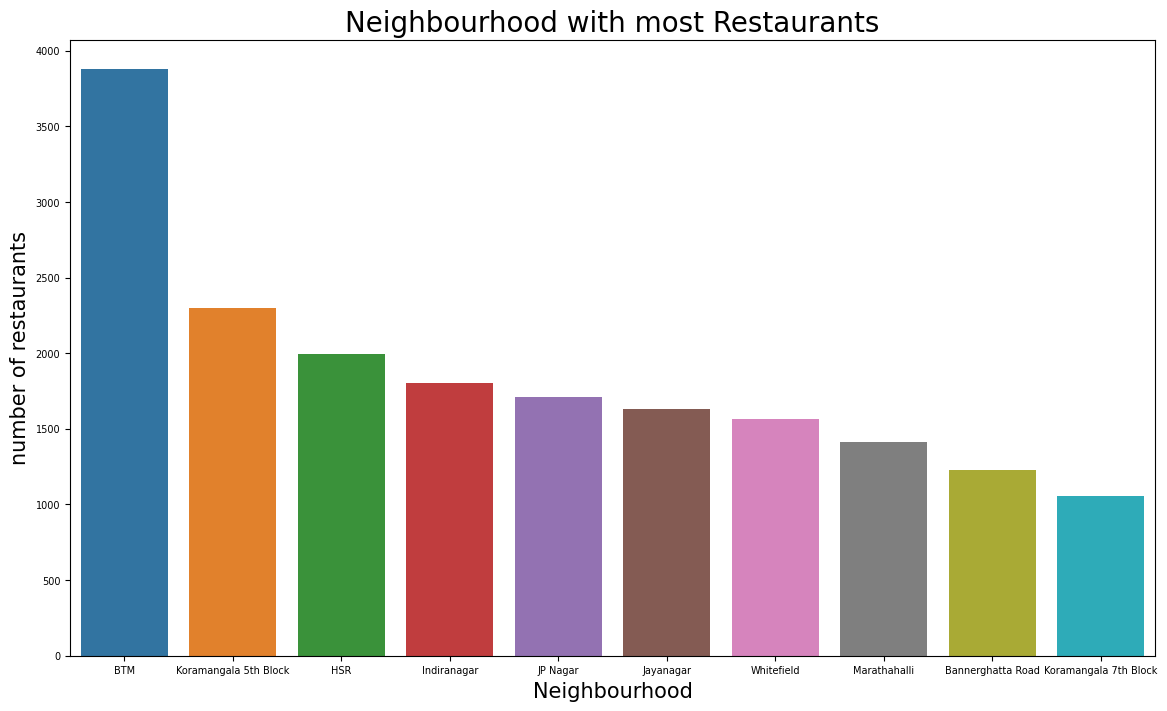

In [12]:
rest_loc = sns.barplot(x=most_rest_loc.keys(),y=most_rest_loc.values,)
rest_loc.axes.set_title("Neighbourhood with most Restaurants",fontsize=20)
rest_loc.set_xlabel("Neighbourhood",fontsize=15)
rest_loc.set_ylabel("number of restaurants",fontsize=15)
rest_loc.tick_params(labelsize=7)


In [167]:
# brand_loc  = pd.DataFrame(df4['name'].value_counts().reset_index())
# brand_loc.columns=['Name','count']

In [195]:
brand_loc = pd.DataFrame(a)

In [196]:
brand_loc

,name,loca,count
0,#FeelTheROLL,Bellandur,2
1,#L-81 Cafe,HSR,9
2,#refuel,Bannerghatta Road,3
3,1000 B.C,Koramangala 5th Block,6
4,100ÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂ°C,BTM,3
...,...,...,...
9179,iFruit Live Ice Creams,Koramangala 1st Block,4
9180,iSpice Resto Cafe,Indiranagar,7
9181,nu.tree,Whitefield,4
9182,nu.tree,Sarjapur Road,3


In [171]:
brands=pd.DataFrame({"Name":df4['name'].unique()})

In [99]:
brr = brand_loc.copy()

In [ ]:
# lat=[]
# lon=[]
# for location in brands['Name']:
#     location = geolocator.geocode(location)    
#     if location is None:
#         lat.append(np.nan)
#         lon.append(np.nan)
#     else:
#         lat.append(location.latitude)
#         lon.append(location.longitude)
lonlang(brr,'loca')

In [184]:
for index, row in locations.iterrows():
    if (row['Name'] == brr['loca']).any():
        print(locations['Name'][index])

Banashankari
Basavanagudi
Mysore Road
Jayanagar
Kumaraswamy Layout
Rajarajeshwari Nagar
Vijay Nagar
Uttarahalli
JP Nagar
South Bangalore
City Market
Bannerghatta Road
BTM
Kanakapura Road
Bommanahalli
Electronic City
Wilson Garden
Shanti Nagar
Koramangala 5th Block
Richmond Road
HSR
Koramangala 7th Block
Bellandur
Sarjapur Road
Marathahalli
Whitefield
East Bangalore
Old Airport Road
Indiranagar
Koramangala 1st Block
Frazer Town
MG Road
Brigade Road
Lavelle Road
Church Street
Ulsoor
Residency Road
Shivajinagar
Infantry Road
St. Marks Road
Cunningham Road
Race Course Road
Commercial Street
Vasanth Nagar
Domlur
Koramangala 8th Block
Ejipura
Jeevan Bhima Nagar
Old Madras Road
Seshadripuram
Kammanahalli
Koramangala 6th Block
Majestic
Langford Town
Central Bangalore
Brookefield
ITPL Main Road, Whitefield
Varthur Main Road, Whitefield
Koramangala 2nd Block
Koramangala 3rd Block
Koramangala 4th Block
Koramangala
Hosur Road
RT Nagar
Banaswadi
North Bangalore
Nagawara
Hennur
Kalyan Nagar
HBR Layo

In [ ]:
for i in range(len(brr['loca'])):
    print(locations['lat'].where(brr['loca'] == locations['Name']))

In [ ]:
for i in range(len(brr['loca'])):
    for index, row in locations.iterrows():
        if (row['Name'] == brr['loca']).any():
            # if (brr['loca'][i] == locations['Name']).any():
                brr.loc[brr['loca']==locations['Name'][index],'lat'] == locations['lat'][index]
                brr.loc[brr['loca']==locations['Name'][index],'lon'] == locations['lon'][index]


In [ ]:
brr['lon']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
9179    0.0
9180    0.0
9181    0.0
9182    0.0
9183    0.0
Name: lon, Length: 9184, dtype: float64

In [161]:
# brand_loc=brand_loc.merge(brands,on='Name',how="left").dropna()

In [ ]:
b_map =  generateBaseMap()

In [ ]:

for i in range(0,len(brr)):
   folium.Circle(
      location=[brr.iloc[i]['lat'], brr.iloc[i]['lon']],
      popup=brr.iloc[i]['name'],
      radius=float(brr.iloc[i]['count']),
      color='crimson',
      fill=True,
      fill_color='crimson'
   ).add_to(b_map)

# Show the map again
b_map

#### Rest loc

In [45]:
Rest_locations=pd.DataFrame(df4['location'].value_counts().reset_index())

In [46]:
Rest_locations.columns=['Name','count']
Rest_locations.head()

,Name,count
0,BTM,3879
1,Koramangala 5th Block,2297
2,HSR,1993
3,Indiranagar,1800
4,JP Nagar,1710


In [47]:
print(locations.shape)
print(Rest_locations.shape)

(92, 3)
(92, 2)


In [48]:
Restaurant_locations=Rest_locations.merge(locations,on='Name',how="left").dropna()
Restaurant_locations.head()

,Name,count,lat,lon
0,BTM,3879,45.954851,-112.496595
1,Koramangala 5th Block,2297,12.934843,77.618977
2,HSR,1993,18.147500,41.538889
3,Indiranagar,1800,12.973291,77.640467
4,JP Nagar,1710,12.265594,76.646540


In [64]:
def generateBaseMap(default_location=[12.97, 77.59], default_zoom_start=12):
    base_map = folium.Map(location=default_location, zoom_start=default_zoom_start)
    return base_map

In [65]:
basemap=generateBaseMap()

In [ ]:
basemap

In [150]:
Restaurant_locations[['lat','lon','count']]

,Name,count,lat,lon
0,BTM,3879,45.954851,-112.496595
1,Koramangala 5th Block,2297,12.934843,77.618977
2,HSR,1993,18.147500,41.538889
3,Indiranagar,1800,12.973291,77.640467
4,JP Nagar,1710,12.265594,76.646540
...,...,...,...,...
87,Yelahanka,4,13.100698,77.596345
88,West Bangalore,3,12.984852,77.540063
89,Rajarajeshwari Nagar,2,12.927441,77.515522
90,Nagarbhavi,1,12.959618,77.511267


In [53]:
HeatMap(Restaurant_locations[['lat','lon','count']],zoom=20,radius=15).add_to(basemap)

In [ ]:
basemap

In [55]:
FastMarkerCluster(data=Restaurant_locations[['lat','lon','count']].values.tolist()).add_to(basemap)

basemap

#### Location and rate map

In [57]:
df4.groupby(['location'])['rate'].mean().sort_values(ascending=False)

location
Lavelle Road             4.141788
Koramangala 3rd Block    4.020419
St. Marks Road           4.017201
Koramangala 5th Block    4.006661
Church Street            3.992125
                           ...   
Rammurthy Nagar          3.346154
North Bangalore          3.340000
Peenya                   3.200000
Bommanahalli             3.190972
Old Madras Road          3.181818
Name: rate, Length: 92, dtype: float64

In [21]:
avg_rating=df4.groupby(['location'])['rate'].mean().values[:10]

TypeError: 'bool' object is not callable

In [20]:
most_rest_loc

BTM                      3879
Koramangala 5th Block    2297
HSR                      1993
Indiranagar              1800
JP Nagar                 1710
Jayanagar                1634
Whitefield               1568
Marathahalli             1410
Bannerghatta Road        1226
Koramangala 7th Block    1055
Name: location, dtype: int64

In [54]:
loc=df4.groupby(['location'])['rate'].mean().index

In [ ]:
loc

In [57]:
geolocator=Nominatim(user_agent="app")

In [15]:
df4['rate']

0        4.1
1        4.1
2        3.8
3        3.7
4        3.8
        ... 
41258    3.7
41259    2.5
41260    3.6
41261    4.3
41262    3.4
Name: rate, Length: 41263, dtype: float64

In [58]:
lat=[]
lon=[]
for location in loc:
    location = geolocator.geocode(location)    
    if location is None:
        lat.append(np.nan)
        lon.append(np.nan)
    else:
        lat.append(location.latitude)
        lon.append(location.longitude)

In [59]:
rating=pd.DataFrame()
rating['location']=loc
rating['lat']=lat
rating['lon']=lon
rating['avg_rating']=avg_rating

In [60]:
rating=rating.dropna()

In [68]:
HeatMap(rating[['lat','lon','avg_rating']],zoom=20,radius=15).add_to(basemap)
basemap

In [66]:
df2= df4[df4['cuisines']=='North Indian']
df2.head()

,level_0,index,address,name,online_order,book_table,rate,votes,location,rest_type,cuisines,cost,reviews_list,menu_item,type,city
5,5,5,"37, 5-1, 4th Floor, Bosco Court, Gandhi Bazaar...",Timepass Dinner,Yes,No,3.8,286,Basavanagudi,Casual Dining,North Indian,600,"[('Rated 3.0', 'RATED\n Food 3/5\nAmbience 3/...",[],Buffet,Banashankari
50,50,50,"276, Ground Floor, 100 Feet Outer Ring Road, B...",Petoo,No,No,3.7,21,Banashankari,Quick Bites,North Indian,450,"[('Rated 2.0', 'RATED\n This is a neatly made...",[],Delivery,Banashankari
85,85,87,"38, 22nd Main, 22nd Cross, Opposite BDA, 2nd S...",Krishna Sagar,No,No,3.5,31,Banashankari,Quick Bites,North Indian,200,"[('Rated 1.0', 'RATED\n Worst experience with...",[],Delivery,Banashankari
90,90,94,"304, Opposite Apollo Public School, 100 Feet R...",Nandhini Deluxe,No,No,2.6,283,Banashankari,Casual Dining,North Indian,600,"[('Rated 3.0', 'RATED\n Ididnt like much.\n\n...",[],Delivery,Banashankari
104,104,109,"8, Katriguppe Main Road, Vivekananda Nagar, 3r...",Katriguppe Donne Biryani,No,No,3.2,4,Banashankari,Quick Bites,North Indian,300,[],[],Delivery,Banashankari


In [48]:
plt.rcParams["figure.figsize"] = (11,7)

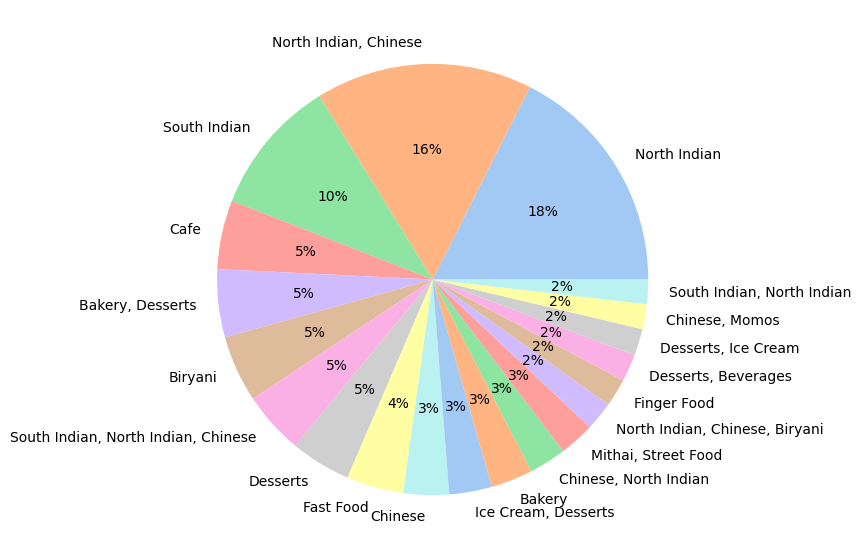

In [49]:
values = df4['cuisines'].value_counts()[:20]
labels=values.index
text=values.index

colors = sns.color_palette('pastel')[0:len(labels)]
plt.pie(values.values, labels=labels, colors=colors,autopct='%.0f%%')
# displaying chart
plt.show()

<AxesSubplot: xlabel='cost', ylabel='online_order'>

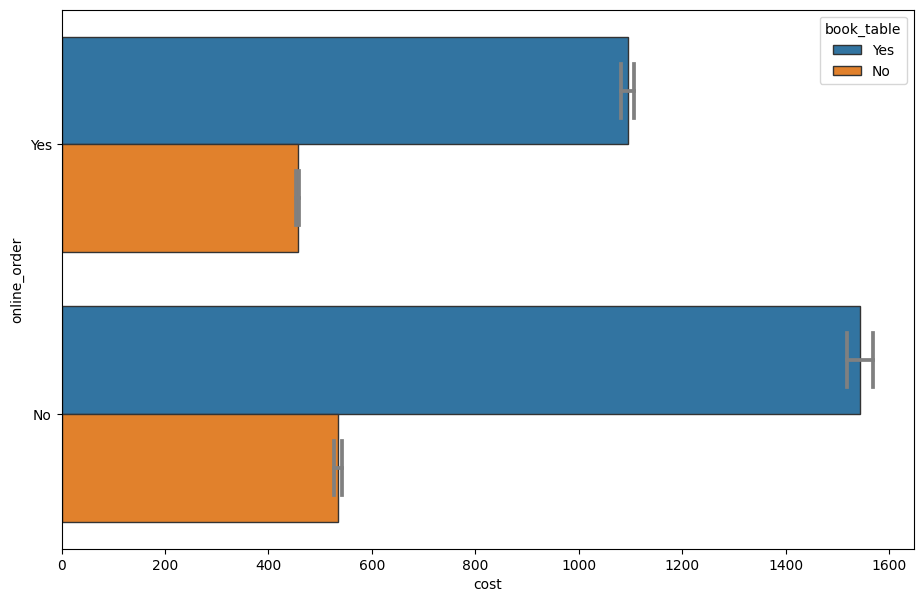

In [141]:
sns.barplot(df4,x='cost',y='online_order',linewidth=1, edgecolor=".2",capsize=.2, errcolor=".5",orient="h",hue='book_table')
# e expect book table more available on restaurants which doesn't accept online orders

<AxesSubplot: xlabel='cost', ylabel='city'>

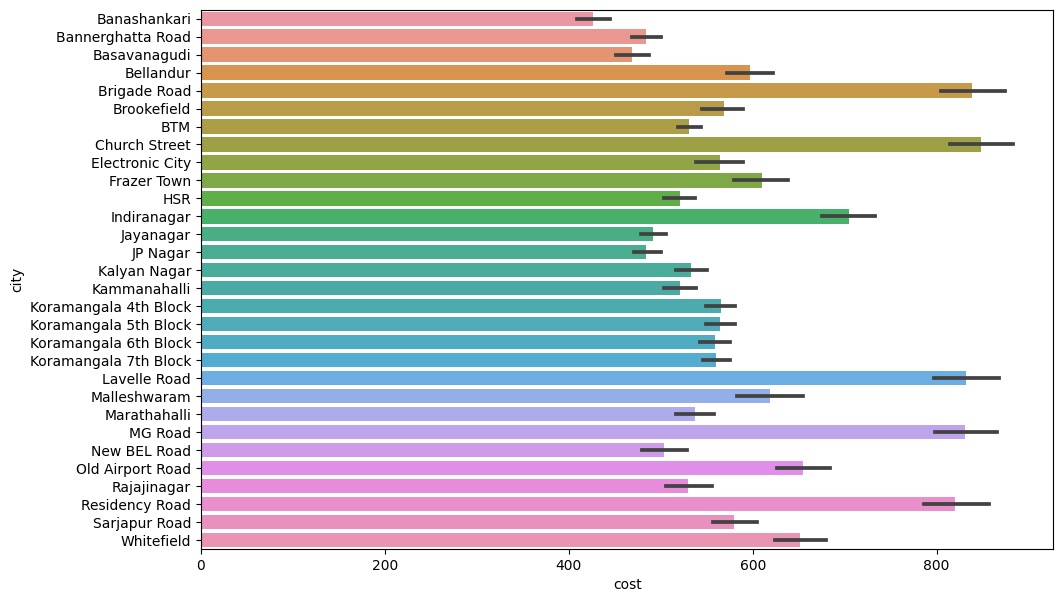

In [148]:
sns.barplot(df4,x='cost',y='city',orient="h")

#### TYPe insights

In [ ]:
avg_type_rating = df4.groupby('type')['rate'].mean()
avg_type_cost = df4.groupby('type')['cost'].mean()
avg_type = df4.type.unique()

<AxesSubplot: ylabel='cost'>

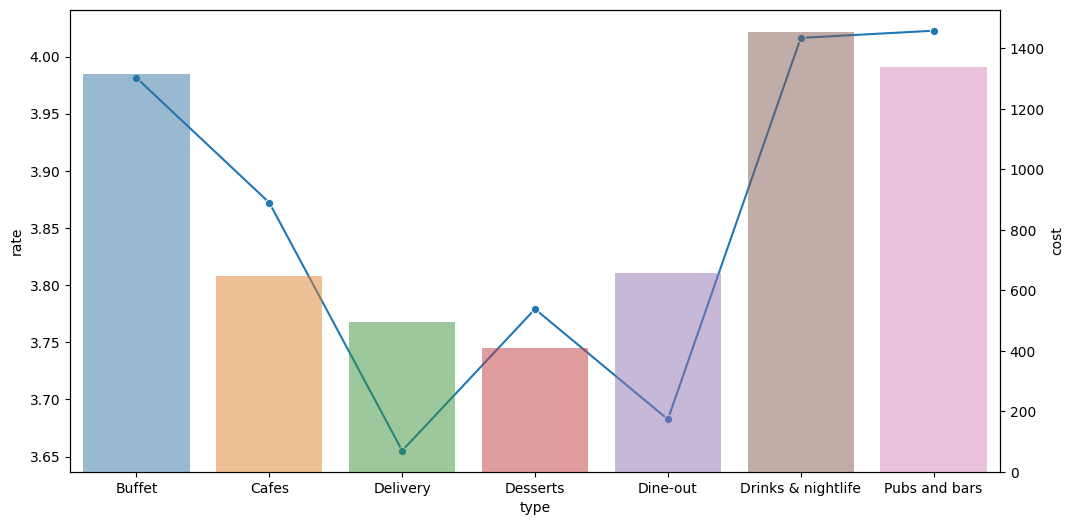

In [45]:
matplotlib.rc_file_defaults()
ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(12,6))

sns.lineplot(data = avg_type_rating, marker='o', sort = False, ax=ax1)
ax2 = ax1.twinx()

sns.barplot( x=avg_type, y=avg_type_cost, alpha=0.5, ax=ax2)

In [78]:
df4['rest_type'].value_counts()

Quick Bites                   13885
Casual Dining                  9614
Cafe                           3369
Dessert Parlor                 1850
Delivery                       1667
                              ...  
Food Court, Beverage Shop         2
Dessert Parlor, Food Court        2
Dessert Parlor, Kiosk             2
Bakery, Beverage Shop             1
Quick Bites, Kiosk                1
Name: rest_type, Length: 87, dtype: int64

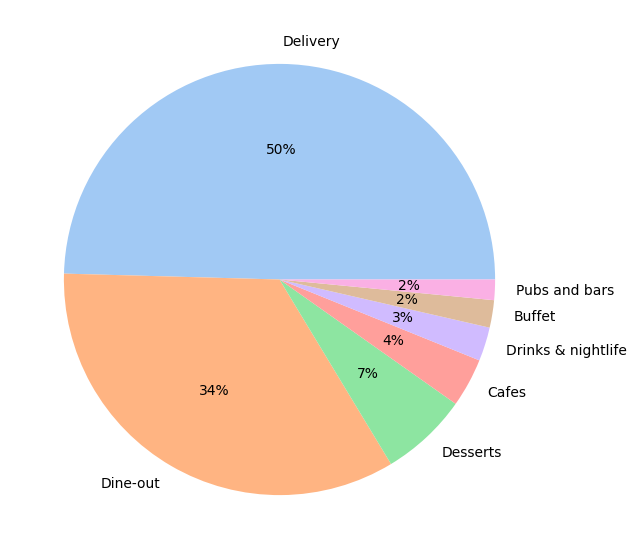

In [75]:
values = df4['type'].value_counts()
labels=values.index
text=values.index

colors = sns.color_palette('pastel')[0:len(labels)]
plt.pie(values.values, labels=labels, colors=colors,autopct='%.0f%%')
# displaying chart
plt.show()

Text(0.5, 0, 'count')

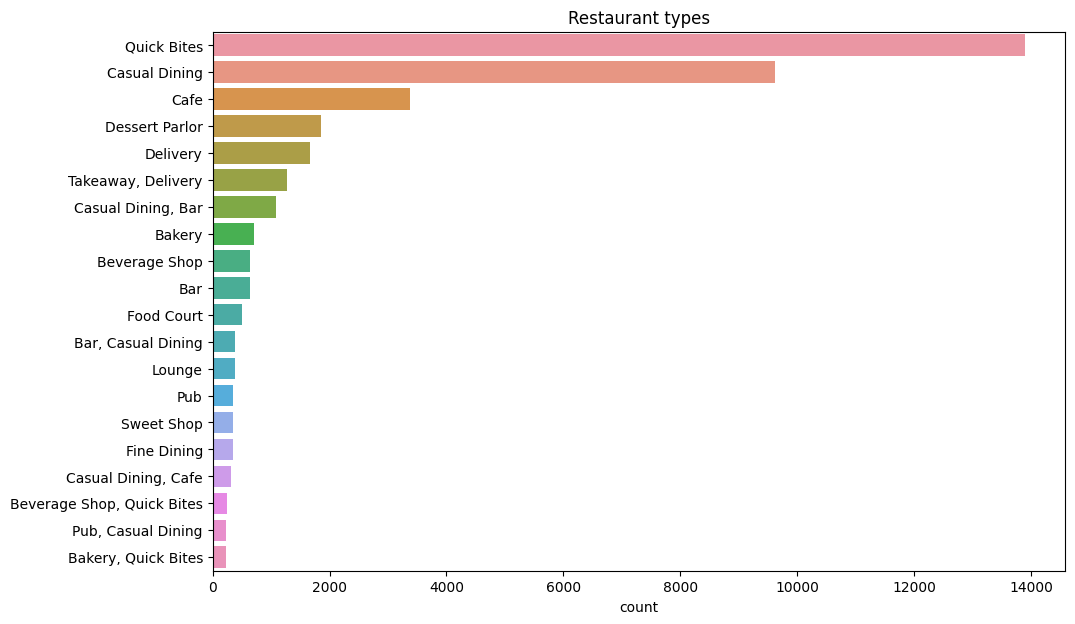

In [80]:
rest=df4['rest_type'].value_counts()[:20]
sns.barplot(x=rest,y=rest.index)
plt.title("Restaurant types")
plt.xlabel("count")

In [86]:
df4

,index,address,name,online_order,book_table,rate,votes,location,rest_type,cuisines,cost,reviews_list,menu_item,type,city
0,0,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1,775,Banashankari,Casual Dining,"North Indian, Mughlai, Chinese",800,[ A beautiful place to dine in.The interiors...,[],Buffet,Banashankari
1,1,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1,787,Banashankari,Casual Dining,"Chinese, North Indian, Thai",800,[ Had been here for dinner with family. Turn...,[],Buffet,Banashankari
2,2,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8,918,Banashankari,"Cafe, Casual Dining","Cafe, Mexican, Italian",800,"[('', ""\n Ambience is not that good enough an...",[],Buffet,Banashankari
3,3,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7,88,Banashankari,Quick Bites,"South Indian, North Indian",300,"[('', ""\n Great food and proper Karnataka sty...",[],Buffet,Banashankari
4,4,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8,166,Basavanagudi,Casual Dining,"North Indian, Rajasthani",600,[ Very good restaurant in neighbourhood. Buf...,[],Buffet,Banashankari
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41258,51709,"136, SAP Labs India, KIADB Export Promotion In...",The Farm House Bar n Grill,No,No,3.7,34,Whitefield,"Casual Dining, Bar","North Indian, Continental",800,[ Ambience- Big and spacious lawn was used t...,[],Pubs and bars,Whitefield
41259,51711,"139/C1, Next To GR Tech Park, Pattandur Agraha...",Bhagini,No,No,2.5,81,Whitefield,"Casual Dining, Bar","Andhra, South Indian, Chinese, North Indian",800,"[ A fine place to chill after office hours, ...",[],Pubs and bars,Whitefield
41260,51712,"Four Points by Sheraton Bengaluru, 43/3, White...",Best Brews - Four Points by Sheraton Bengaluru...,No,No,3.6,27,Whitefield,Bar,Continental,1500,"[('', ""\n Food and service are incomparably e...",[],Pubs and bars,Whitefield
41261,51715,Sheraton Grand Bengaluru Whitefield Hotel & Co...,Chime - Sheraton Grand Bengaluru Whitefield Ho...,No,Yes,4.3,236,"ITPL Main Road, Whitefield",Bar,Finger Food,2500,[ Nice and friendly place and staff is aweso...,[],Pubs and bars,Whitefield


##### REviews and ratings csv creation
We will take reviews_lists seeprate them in a rows. 
Our dataframe will be constitued from review rating and restaurant name, then we will process it with NLP methods 

In [66]:
all_ratings = []

for name,ratings in tqdm(zip(df2['name'],df2['reviews_list'])):
    ratings = eval(ratings)
    for score, doc in ratings:
        if score:
            score = score.strip("Rated").strip()
            doc = doc.strip('RATED').strip()
            score = float(score)
            all_ratings.append([name,score, doc])
rating_df = pd.DataFrame(all_ratings,columns=['name','rating','review'])
rating_df['review']=rating_df['review'].apply(lambda x : re.sub('[^a-zA-Z0-9\s]',"",x))
rating_df.to_csv("./dbs/ratingsandreviews.csv")

46443it [00:25, 1851.17it/s]


In [74]:
rating_df.head()

,name,rating,review
0,Jalsa,4.0,A beautiful place to dine inThe interiors take...
1,Jalsa,4.0,I was here for dinner with my family on a week...
2,Jalsa,2.0,Its a restaurant near to Banashankari BDA Me a...
3,Jalsa,4.0,We went here on a weekend and one of us had th...
4,Jalsa,5.0,The best thing about the place is its ambiance...
